<a href="https://colab.research.google.com/github/ChecinskiBartlomiej/ML/blob/main/UM_hw_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*



For this project I will use BERT language model for embeddings. Based on transformer architecture BERT is capable of capturing semantic structure of text using $768$ dimensional vectors to represent tokens.

In [1]:
# Initialize Bert Tokenizer and Bert Model.
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

BERT has $30522$ tokens in its vocabulary. Because not every word is in vocabulary (it might be composed as some of the tokens from vocabulary), to have one vector representation for word I will average coordinates of tokens which build this word.

In [5]:
# Function which outputs mean of embeddings of word's tokens.
import torch
def get_word_embedding(word):
    token_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word))
    embeddings = model.get_input_embeddings()
    with torch.no_grad():
        token_embeddings = embeddings(torch.tensor(token_ids))
    return token_embeddings.mean(dim=0)

Now I will manually build a dictionary of classess and pairs of words which belongs to these classes. Each class is conceptually coherent.

In [3]:
semantic_classes = {
    "gender": [
        ("king", "queen"),
        ("man", "woman"),
        ("doctor", "nurse"),
        ("prince", "princess"),
        ("husband", "wife")
    ],
    "verb_tense_present_past": [
        ("bring", "brought"),
        ("get", "got"),
        ("like", "liked"),
        ("go", "went"),
        ("see", "saw")
    ],
    "country_capital": [
        ("France", "Paris"),
        ("Japan", "Tokyo"),
        ("Poland", "Warsaw"),
        ("England", "London"),
        ("Germany", "Berlin")
    ],
    "antonyms": [
        ("hot", "cold"),
        ("happy", "sad"),
        ("light", "dark"),
        ("young", "old"),
        ("full", "empty")
    ],
    "country_currency": [
        ("Mexico", "peso"),
        ("India", "rupee"),
        ("Spain", "euro"),
        ("Hungary", "forint"),
        ("Poland", "złoty")
    ],
    "gender_animal_male_female": [
        ("lion", "lioness"),
        ("bull", "cow"),
        ("rooster", "hen"),
        ("ram", "ewe"),
        ("boar", "sow")
    ],
    "animal_meat": [
        ("cow", "beef"),
        ("pig", "pork"),
        ("deer", "venison"),
        ("sheep", "mutton"),
        ("goat", "chevon")
    ],
    "musician_instrument": [
        ("guitarist", "guitar"),
        ("pianist", "piano"),
        ("drummer", "drums"),
        ("violinist", "violin"),
        ("saxophonist", "saxophone")
    ],
    "us_state_capital": [
        ("California", "Sacramento"),
        ("Texas", "Austin"),
        ("Florida", "Tallahassee"),
        ("Illinois", "Springfield"),
        ("Hawaii", "Honolulu")
    ],
    "positive_comperative": [
        ("good", "better"),
        ("nice", "nicer"),
        ("tall", "taller"),
        ("big", "bigger"),
        ("dry", "drier")
    ]
}

For convenience I will extract words and its embeddings to long lists and stack embeddings for PCA.

In [7]:
import numpy as np
embeddings = []
words = []

for class_name, pairs in semantic_classes.items():
    for w1, w2 in pairs:
        e1 = get_word_embedding(w1)
        e2 = get_word_embedding(w2)
        embeddings.append(e1.cpu().numpy())
        words.append(w1)
        embeddings.append(e2.cpu().numpy())
        words.append(w2)
X = np.vstack(embeddings)

Now we are ready to reduce dimensionality and visually inspect our embeddings.

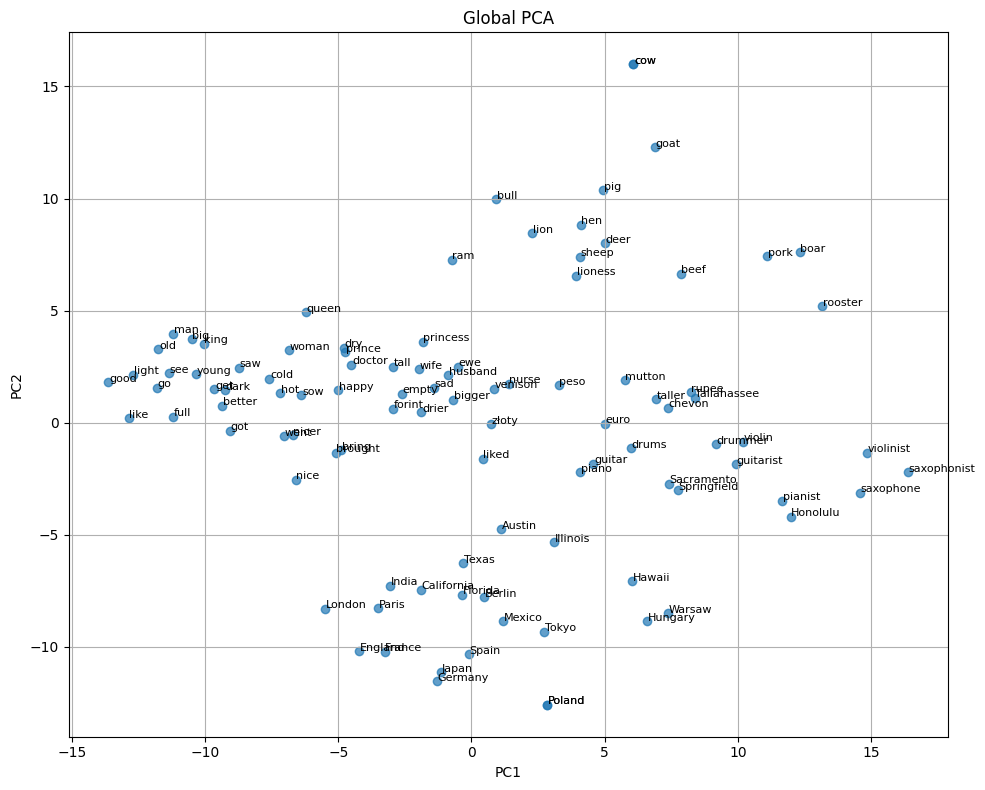

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Perform PCA.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot global PCA.
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
for i, word in enumerate(words):
    x, y = X_pca[i]
    plt.text(x + 0.02, y + 0.02, word, fontsize=8)

plt.title("Global PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot gives some insight. Look at them bottom. Countries and cities are clumped together. On the right we can see words from musician and instrument class. Animals and meat on the top. On the left side there are adjectives close to human-denoting nouns.

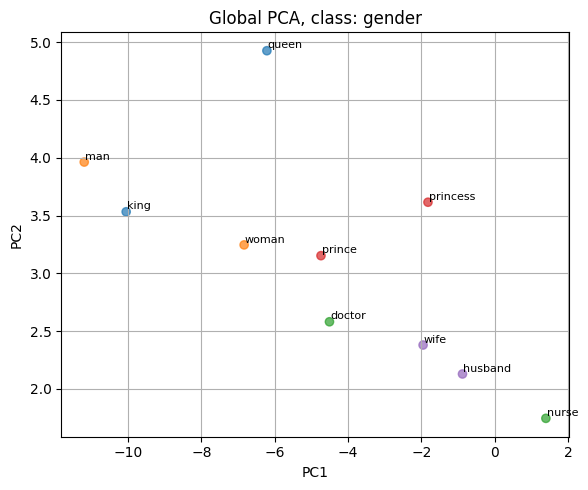

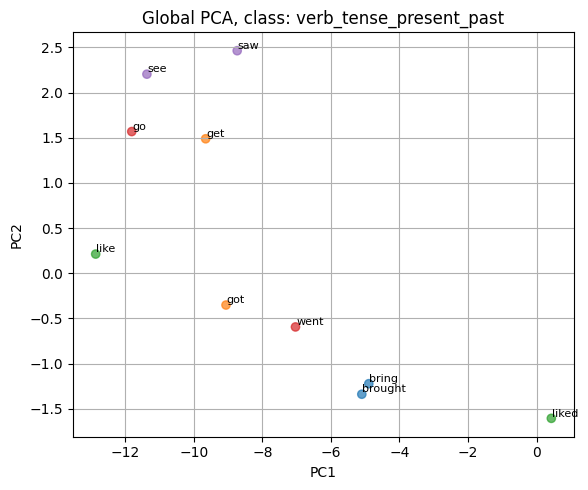

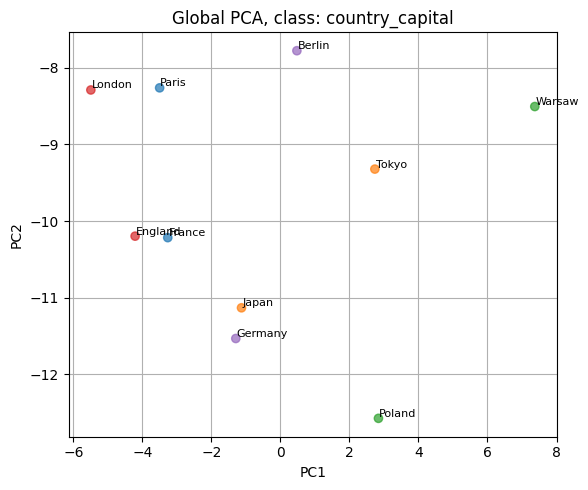

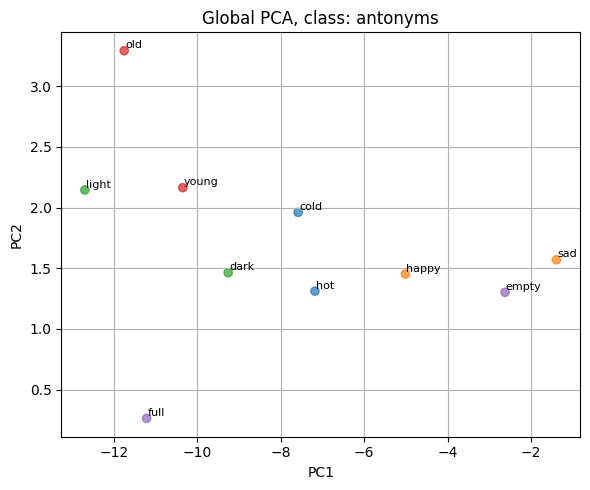

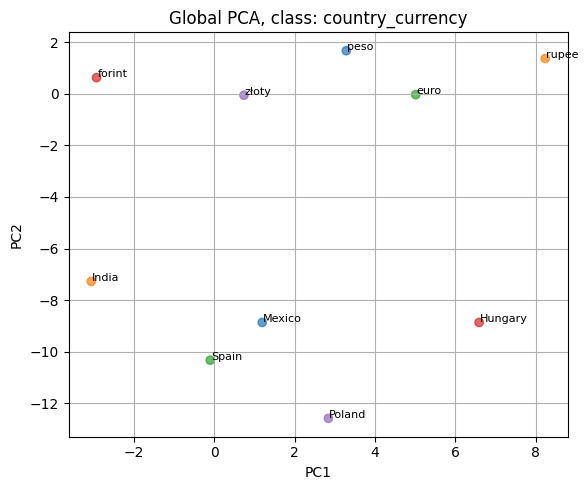

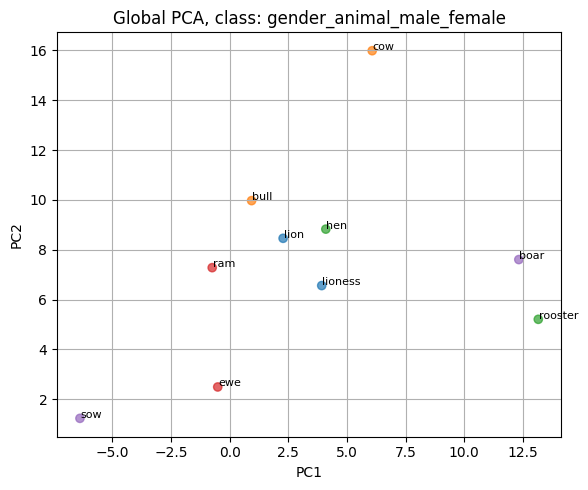

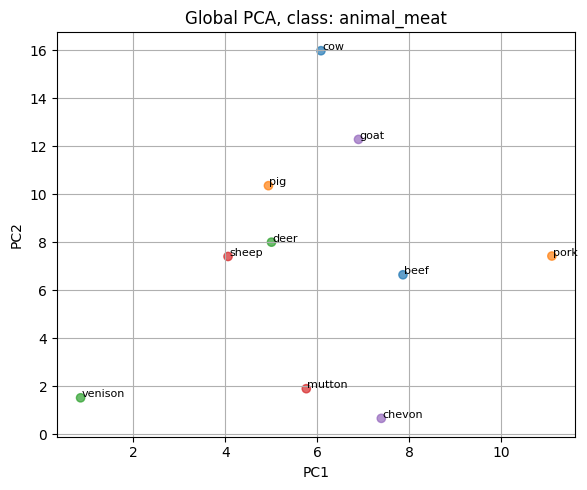

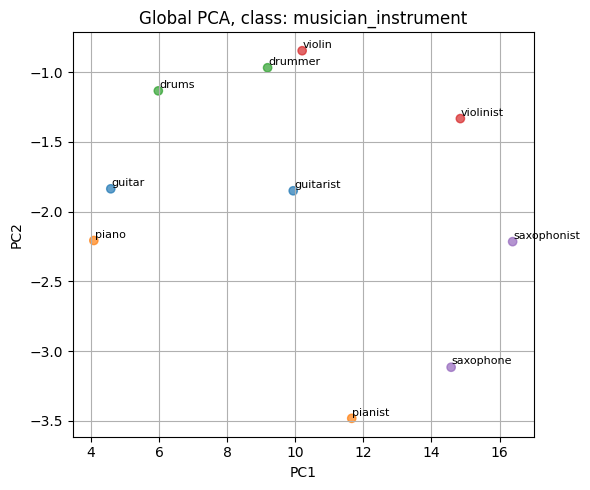

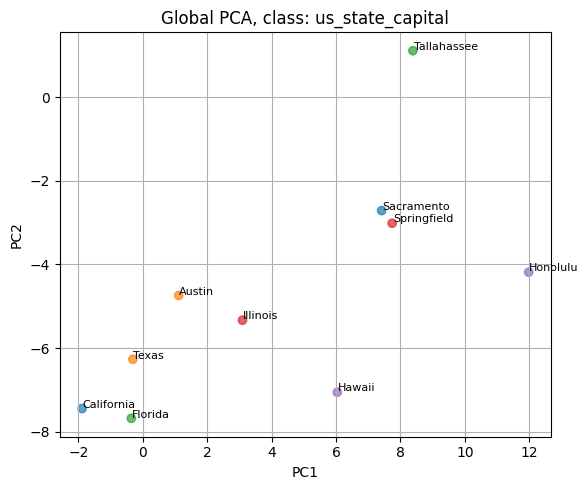

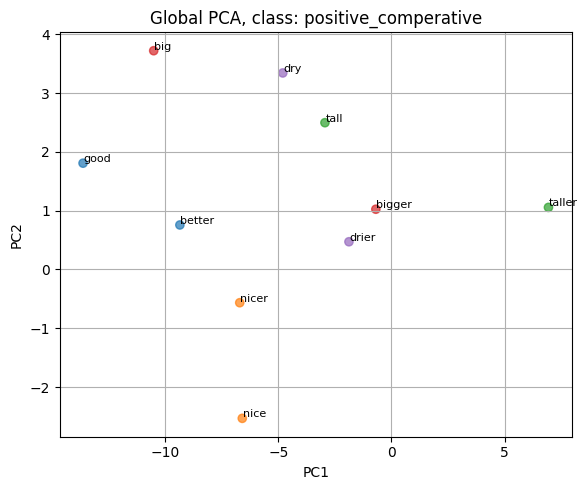

In [13]:
# Plot global PCA, but one class per image.
classes_list = list(semantic_classes.keys())
for j, class_name in enumerate(classes_list):
    start = 10 * j
    end = start + 10
    coords = X_pca[start:end]
    labels = words[start:end]

    cmap = plt.colormaps.get_cmap('tab10')
    pair_colors = [cmap(i) for i in range(5)]
    colors = []
    for pair_idx in range(5):
        colors.append(pair_colors[pair_idx])
        colors.append(pair_colors[pair_idx])

    plt.figure(figsize=(6, 5))
    plt.scatter(coords[:, 0], coords[:, 1], c=colors, alpha=0.7)
    for k, word in enumerate(labels):
        x, y = coords[k]
        plt.text(x + 0.02, y + 0.02, word, fontsize=8)

    plt.title(f"Global PCA, class: {class_name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

These separated charts shed additional light. Visually, you can confirm that each class's words remain roughly in the same subregion of the 2D space. Some classes form tighter clouds, others spread out more. Plot with countries and currencies is interesting. There you can clearly separate those two.

Now I will perform $10$ PCA's, one for each class.

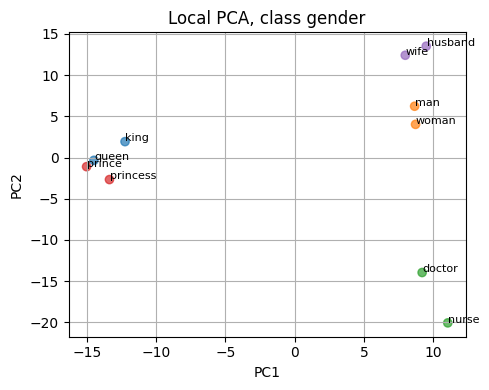

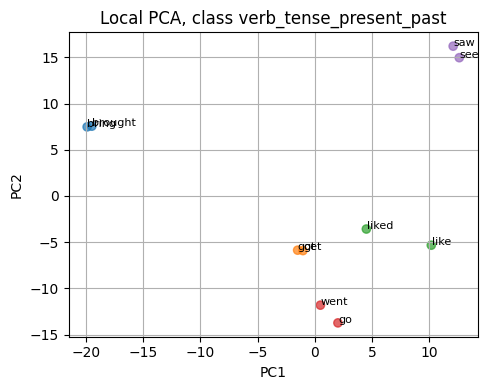

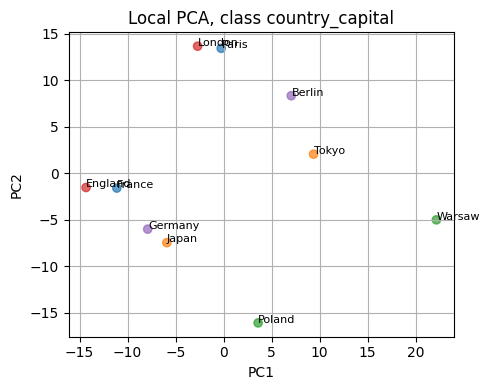

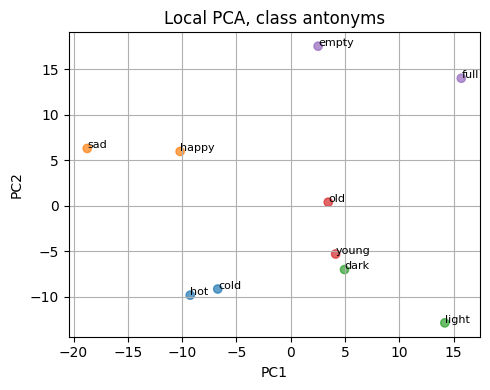

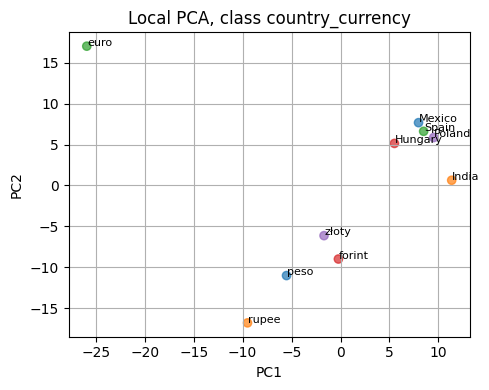

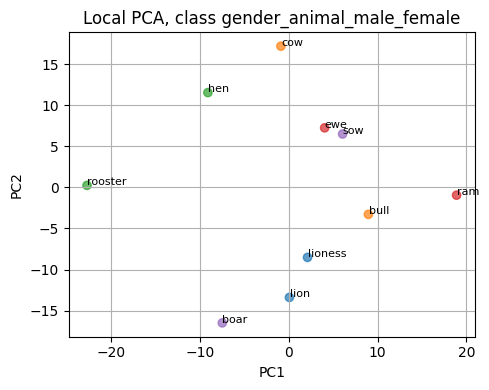

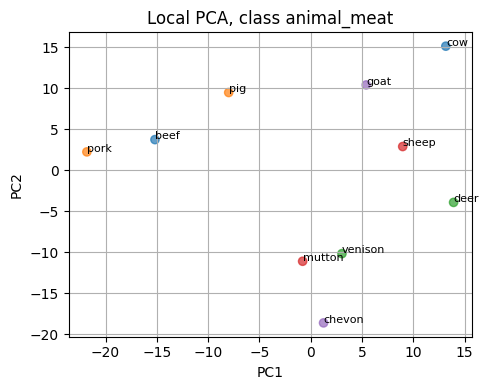

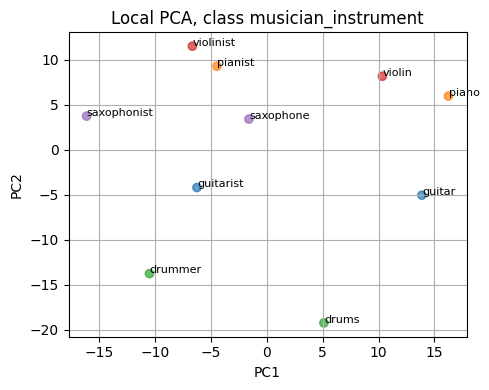

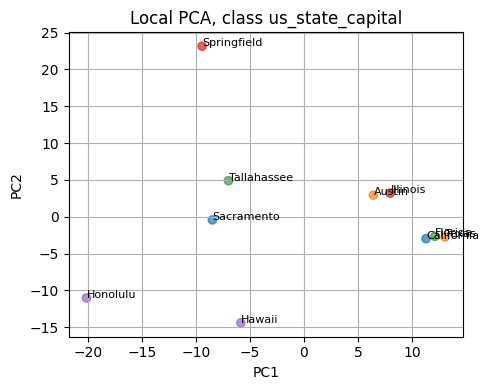

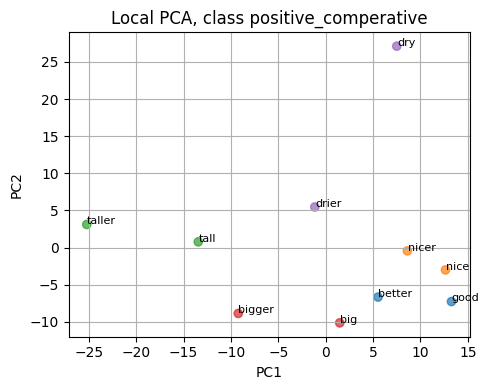

In [15]:
# Plot 10 PCA's, one for each class.
for j, class_name in enumerate(classes_list):
    start = 10 * j
    end = start + 10
    Xj = X_scaled[start:end]
    labels_j = words[start:end]
    pca_j  = PCA(n_components=2)
    Xj_pca = pca_j.fit_transform(Xj)

    cmap = plt.colormaps.get_cmap('tab10')
    pair_colors = [cmap(i) for i in range(5)]
    colors = []
    for pair_idx in range(5):
        colors.append(pair_colors[pair_idx])
        colors.append(pair_colors[pair_idx])

    plt.figure(figsize=(5, 4))
    plt.scatter(Xj_pca[:, 0], Xj_pca[:, 1], c=colors, alpha=0.7)
    for k, word in enumerate(labels_j):
        x, y = Xj_pca[k]
        plt.text(x + 0.02, y + 0.02, word, fontsize=8)
    plt.title(f"Local PCA, class {class_name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In the first and second figures, the words are beautifully separated, with each pair located very close together. In the third figure, the difference vectors between pairs are roughly the same length. The plot showing countries and currencies is also intriguing—notice that “Euro” is positioned noticeably farther away from the other terms.

Now let's examine arithmetic of embeddings.

In [16]:
# For each class calculate B-A+C, find 5 closest words, check if it is close to D, where (A,B), (C,D) are embeddings of two first pairs
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()

def find_top_5_neighbors(S):
    diffs = embedding_matrix - S
    dists = np.linalg.norm(diffs, axis=1)
    topk_indices = np.argsort(dists)[:5]
    neighbors = []
    for idx in topk_indices:
        token_str = tokenizer.convert_ids_to_tokens([idx])[0]
        neighbors.append((token_str, float(dists[idx])))
    return neighbors

for j, class_name in enumerate(classes_list):
    start = 10 * j
    A = embeddings[start]
    B = embeddings[start+1]
    C = embeddings[start+2]
    S = B - A + C
    top5 = find_top_5_neighbors(S)
    print(f"5 closest embeddings to {words[start+1]} - {words[start]} + {words[start+2]}:")
    for token, dist in top5:
        print(f"{token}  dist = {dist:.4f}")


5 closest embeddings to queen - king + man:
man  dist = 0.8863
woman  dist = 0.9948
girl  dist = 1.1095
queen  dist = 1.1463
women  dist = 1.2499
5 closest embeddings to brought - bring + get:
get  dist = 0.6286
got  dist = 0.8278
getting  dist = 0.8756
gets  dist = 0.8949
gotten  dist = 1.0828
5 closest embeddings to Paris - France + Japan:
japan  dist = 0.9052
paris  dist = 1.0065
japanese  dist = 1.1513
london  dist = 1.2236
tokyo  dist = 1.2393
5 closest embeddings to cold - hot + happy:
happy  dist = 1.1352
cold  dist = 1.2640
unhappy  dist = 1.4867
angry  dist = 1.5138
happiness  dist = 1.5162
5 closest embeddings to peso - Mexico + India:
india  dist = 1.1950
pe  dist = 1.3192
##so  dist = 1.4115
indian  dist = 1.4724
1895  dist = 1.4936
5 closest embeddings to lioness - lion + bull:
bull  dist = 0.8168
##ess  dist = 1.2790
bulls  dist = 1.4486
1847  dist = 1.4577
1949  dist = 1.4657
5 closest embeddings to beef - cow + pig:
beef  dist = 1.3548
pig  dist = 1.4370
meat  dist = 1.

In most cases, the expected word (D) appears among the top five nearest neighbors, although it is never the very closest. Some tokens that show up are unusual—for example, in the U.S. states and capitals class, three [unused] tokens appear. Those exist to support fine-tuning, allowing users to add new entries to the vocabulary. You'll also sometimes see numeric tokens or subword fragments like ##ess.